In [38]:
import pandas as pd
import numpy as np
from metpy import calc
from metpy.units import units
from matplotlib import pyplot as plt

In [121]:
hailsonde_filename = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_hailsonde/2023-07-24_1631_9931.raw_flight_history.csv'

In [138]:
#read windsond fligt
df = pd.read_csv(hailsonde_filename, header=0, skipinitialspace=True)
raw_dict = df.to_dict(orient='list')

hs_pres = np.array(raw_dict['Pressure (Pascal)'])/100
hs_hght = np.array(raw_dict['Altitude (m MSL)'])
hs_tmpc = np.array(raw_dict['Temperature (C)'])
hs_rh = np.array(raw_dict['Relative humidity (%)'])
hs_wdir = np.array(raw_dict['Heading (degrees)'])
hs_wspd = np.array(raw_dict['Speed (m/s)'])
hs_rise = np.array(raw_dict['Rise speed (m/s)'])
hs_utc_time = np.array(raw_dict["UTC time"])

#filter nan
nan_mask = np.isnan(hs_wspd)
hs_pres = hs_pres[~nan_mask]
hs_hght = hs_hght[~nan_mask]
hs_tmpc = hs_tmpc[~nan_mask]
hs_rh = hs_rh[~nan_mask]
hs_wdir = hs_wdir[~nan_mask]
hs_wspd = hs_wspd[~nan_mask]
hs_rise = hs_rise[~nan_mask]
hs_utc_time = hs_utc_time[~nan_mask]

#convert wind to u,v
hs_wind_u, hs_wind_v = calc.wind_components(hs_wspd*units.meter/units.second, hs_wdir*units.degree)

In [ ]:
windsond_filename = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_hailsonde/2023-07-24_1517_9929.raw_flight_history.csv'

In [92]:
#read windsond fligt
df = pd.read_csv(windsond_filename, header=0, skipinitialspace=True)
raw_dict = df.to_dict(orient='list')

ws_pres = np.array(raw_dict['Pressure (Pascal)'])/100
ws_hght = np.array(raw_dict['Altitude (m MSL)'])
ws_tmpc = np.array(raw_dict['Temperature (C)'])
ws_rh = np.array(raw_dict['Relative humidity (%)'])
ws_wdir = np.array(raw_dict['Heading (degrees)'])
ws_wspd = np.array(raw_dict['Speed (m/s)'])
ws_rise = np.array(raw_dict['Rise speed (m/s)'])
ws_utc_time = np.array(raw_dict["UTC time"])

#convert wind to u,v
ws_wind_u, ws_wind_v = calc.wind_components(ws_wspd*units.meter/units.second, ws_wdir*units.degree)

In [78]:
#correct T
pre_jump_idx = 52
post_jump_idx = 54
ws_tmpc_offset = ws_tmpc[post_jump_idx] - ws_tmpc[pre_jump_idx]
ws_tmpc_corrected = ws_tmpc.copy()
ws_tmpc_corrected[pre_jump_idx+1:] = ws_tmpc_corrected[pre_jump_idx+1:]-ws_tmpc_offset
ws_tmpc_corrected[pre_jump_idx+1] = ws_tmpc_corrected[pre_jump_idx] #replace jump in data with previous value (weird spike!)


#correct RH
pre_jump_idx = 111
post_jump_idx = 145
ws_rh_corrected = rh.copy()
ws_rh_corrected[pre_jump_idx:post_jump_idx] = ws_rh_corrected[pre_jump_idx:post_jump_idx] - 100

pre_jump_idx = 191
post_jump_idx = 200
ws_rh_corrected[pre_jump_idx:post_jump_idx] = ws_rh_corrected[pre_jump_idx:post_jump_idx] + 100

Text(0.5, 1.0, 'Corrected Data')

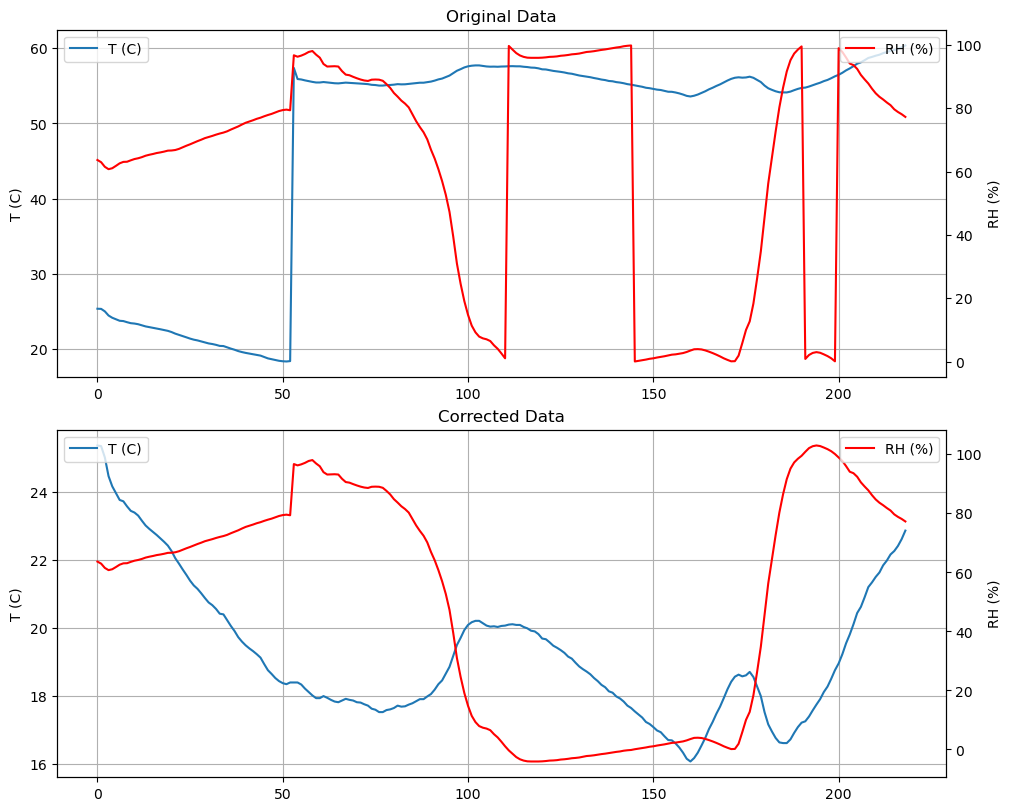

In [79]:
fig = plt.figure(constrained_layout = True, figsize = (10, 8))

ax = plt.subplot(211)
ax.plot(ws_tmpc, label='T (C)')
ax.set_ylabel('T (C)')
ax2 = ax.twinx()
ax2.plot(ws_rh, 'r-', label='RH (%)')
ax2.set_ylabel('RH (%)')
ax.grid()
ax.legend(loc=2)
ax2.legend(loc=1)
ax.set_title('Original Data')


ax = plt.subplot(212)
ax.plot(ws_tmpc_corrected, label='T (C)')
ax.set_ylabel('T (C)')
ax2 = ax.twinx()
ax2.plot(ws_rh_corrected, 'r-', label='RH (%)')
ax2.set_ylabel('RH (%)')
ax.grid()
ax.legend(loc=2)
ax2.legend(loc=1)
ax.set_title('Corrected Data')



Text(0, 0.5, 'Alt (m)')

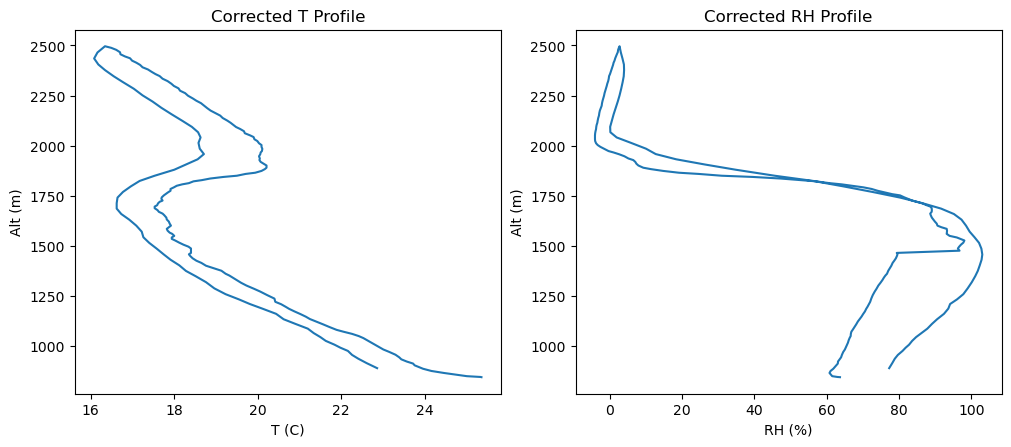

In [80]:
fig = plt.figure(constrained_layout = True, figsize = (10, 8))

ax = plt.subplot(221)
ax.set_title('Corrected T Profile')
ax.plot(ws_tmpc_corrected, ws_hght, label='T (C)')
ax.set_xlabel('T (C)')
ax.set_ylabel('Alt (m)')

ax = plt.subplot(222)
ax.set_title('Corrected RH Profile')
ax.plot(ws_rh_corrected, ws_hght, label='RH (%)')
ax.set_xlabel('RH (%)')
ax.set_ylabel('Alt (m)')


In [100]:
#read ECCC RS41
from bs4 import BeautifulSoup 
from datetime import datetime
import numpy as np

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

snd_ffn = '/g/data/kl02/jss548/hail-research/hailsonde/20230723_stony_plain_sondes/stony_plain_exp_ua_20230723_231518.xml'
with open(snd_ffn, 'r') as f:
    data = f.read() 

# Passing the stored data inside the beautifulsoup parser 
bs_data = BeautifulSoup(data, "lxml") 
ec_dt_list = []
ec_dts_list = []
ec_rh_list = []
ec_hght_list = []
ec_pres_list = []
ec_temp_list = []
ec_wdir_list = []
ec_wspd_list = []
for row in bs_data.find_all('row'):
    ec_dt_list.append(datetime.strptime(row.get('datasrvtime')[:-3],'%Y-%m-%dT%H:%M:%S.%f')) #python datetime
    ec_dts_list.append(row.get('datasrvtime')) #datetime string
    ec_hght_list.append(float(row.get('altitude'))) #m AMSL
    ec_rh_list.append(float(row.get('humidity'))) #RH
    ec_pres_list.append(float(row.get('pressure'))) #pressure hpa
    ec_temp_list.append(float(row.get('temperature'))) #K
    ec_wdir_list.append(float(row.get('winddir'))) #degTN
    ec_wspd_list.append(float(row.get('windspeed'))) #m/s

ec_rh_array = np.array(ec_rh_list)
ec_hght_array = np.array(ec_hght_list)
ec_pres_array = np.array(ec_pres_list)
ec_temp_array = np.array(ec_temp_list) - 273.15
ec_wdir_array = np.array(ec_wdir_list)
ec_wspd_array = np.array(ec_wspd_list)

windsond profile T cutoff height 2466m
windsond profile RH cutoff height 1465m


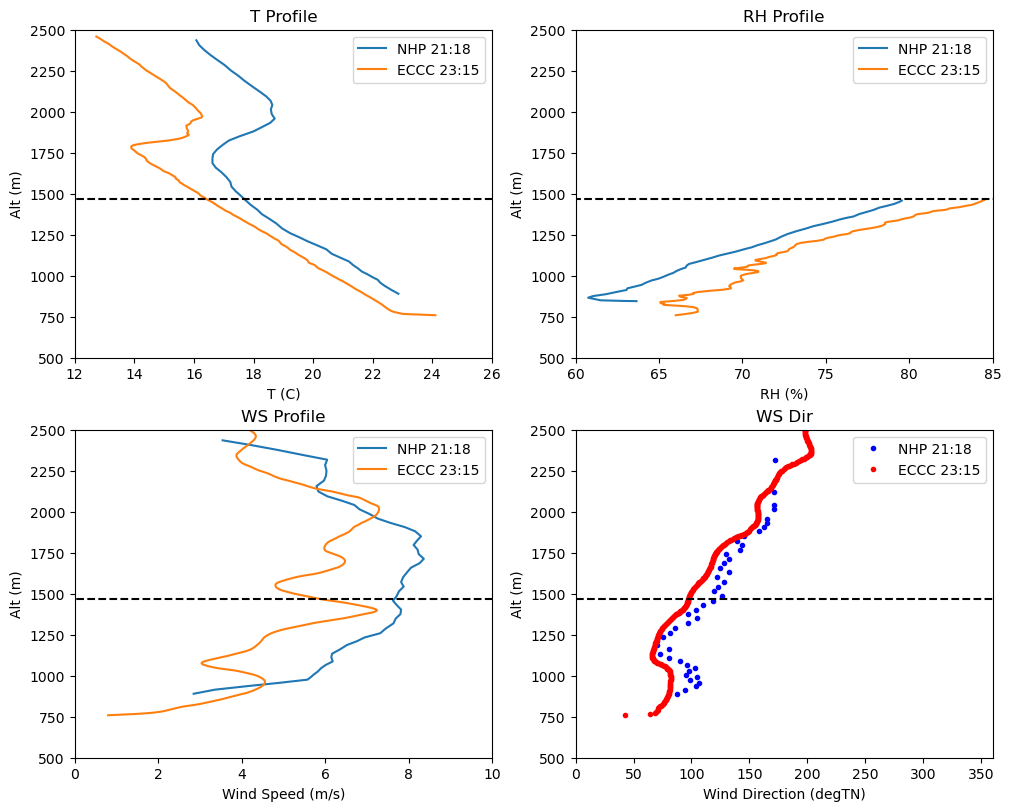

In [120]:
ws_tmp_profile_cutoff = 155
ws_rh_profile_cutoff = 52

ws_tmp_profile_hght = ws_hght[ws_tmp_profile_cutoff]
ws_rh_profile_hght = ws_hght[ws_rh_profile_cutoff]

ec_tmp_profile_idx = np.argmin(np.abs(ws_tmp_profile_hght - ec_hght_array))
ec_rh_profile_idx = np.argmin(np.abs(ws_rh_profile_hght - ec_hght_array))

print(f'windsond profile T cutoff height {ws_hght[ws_tmp_profile_cutoff]}m')
print(f'windsond profile RH cutoff height {ws_hght[ws_rh_profile_cutoff]}m')


fig = plt.figure(constrained_layout = True, figsize = (10, 8))

ax = plt.subplot(221)
ax.set_title('T Profile')
ax.plot(ws_tmpc_corrected[ws_tmp_profile_cutoff+5:], ws_hght[ws_tmp_profile_cutoff+5:], label='NHP 21:18')
ax.plot(ec_temp_array[:ec_tmp_profile_idx], ec_hght_array[:ec_tmp_profile_idx], label='ECCC 23:15')
ax.plot([-100,100],[ws_rh_profile_hght,ws_rh_profile_hght], '--k')
ax.set_xlabel('T (C)')
ax.set_ylabel('Alt (m)')
ax.set_ylim([500,2500])
ax.set_xlim([12,26])
ax.legend()

ax = plt.subplot(222)
ax.set_title('RH Profile')
ax.plot(ws_rh_corrected[:ws_rh_profile_cutoff], ws_hght[:ws_rh_profile_cutoff], label='NHP 21:18')
ax.plot(ec_rh_array[:ec_rh_profile_idx], ec_hght_array[:ec_rh_profile_idx], label='ECCC 23:15')
ax.plot([-100,100],[ws_rh_profile_hght,ws_rh_profile_hght], '--k')
ax.set_xlabel('RH (%)')
ax.set_ylabel('Alt (m)')
ax.set_ylim([500,2500])
ax.set_xlim([60,85])
ax.legend()

ax = plt.subplot(223)
ax.set_title('WS Profile')
ax.plot(smooth(ws_wspd[ws_tmp_profile_cutoff+5:], 9), ws_hght[ws_tmp_profile_cutoff+5:], label='NHP 21:18')
ax.plot(ec_wspd_array, ec_hght_array, label='ECCC 23:15')
ax.plot([-100,100],[ws_rh_profile_hght,ws_rh_profile_hght], '--k')
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Alt (m)')
ax.set_ylim([500,2500])
ax.set_xlim([0,10])
ax.legend()

ax = plt.subplot(224)
ax.set_title('WS Dir')
ax.plot(ws_wdir[ws_tmp_profile_cutoff+5:]-180, ws_hght[ws_tmp_profile_cutoff+5:], 'b.', label='NHP 21:18')
ax.plot(ec_wdir_array, ec_hght_array, 'r.', label='ECCC 23:15')
ax.plot([0,360],[ws_rh_profile_hght,ws_rh_profile_hght], '--k')
ax.set_xlabel('Wind Direction (degTN)')
ax.set_ylabel('Alt (m)')
ax.set_ylim([500,2500])
ax.set_xlim([0,360])
ax.legend()


# ax = plt.subplot(222)
# ax.set_title('RH Profile')
# ax.plot(ws_rh_corrected[:ws_rh_profile_cutoff], ws_hght[:ws_rh_profile_cutoff], label='NHP')
# ax.plot(ec_rh_array[:ec_rh_profile_idx], ws_hght[:ec_rh_profile_idx], label='EC')
# ax.set_xlabel('RH (%)')
# ax.set_ylabel('Alt (m)')
# ax.legend()

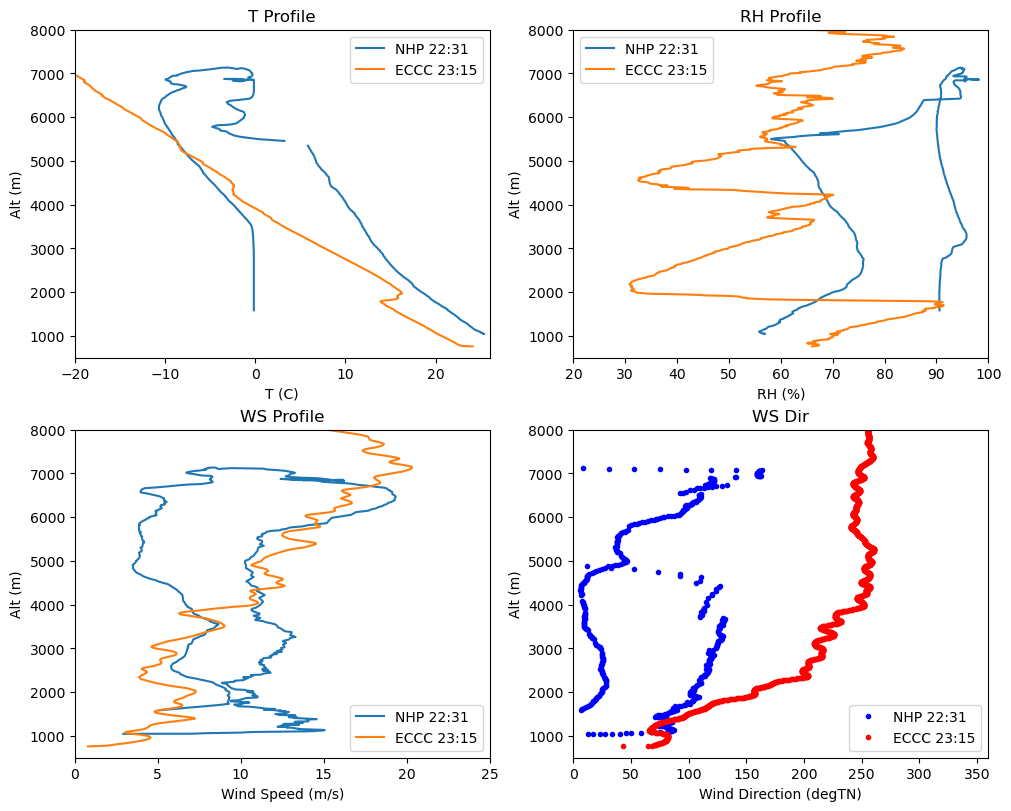

In [147]:
fig = plt.figure(constrained_layout = True, figsize = (10, 8))

hs_idx = 300

ax = plt.subplot(221)
ax.set_title('T Profile')
ax.plot(hs_tmpc, hs_hght, label='NHP 22:31')
ax.plot(ec_temp_array, ec_hght_array, label='ECCC 23:15')
ax.set_xlabel('T (C)')
ax.set_ylabel('Alt (m)')
ax.set_ylim([500,8000])
ax.set_xlim([-20,26])
ax.legend()

ax = plt.subplot(222)
ax.set_title('RH Profile')
ax.plot(hs_rh, hs_hght, label='NHP 22:31')
ax.plot(ec_rh_array, ec_hght_array, label='ECCC 23:15')
ax.set_xlabel('RH (%)')
ax.set_ylabel('Alt (m)')
ax.set_ylim([500,8000])
ax.set_xlim([20,100])
ax.legend()

ax = plt.subplot(223)
ax.set_title('WS Profile')
ax.plot(smooth(hs_wspd, 15), hs_hght, label='NHP 22:31')
ax.plot(ec_wspd_array, ec_hght_array, label='ECCC 23:15')
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Alt (m)')
ax.set_ylim([500,8000])
ax.set_xlim([0,25])
ax.legend()

ax = plt.subplot(224)
ax.set_title('WS Dir')
ax.plot(smooth(hs_wdir-180, 15), hs_hght, 'b.', label='NHP 22:31')
ax.plot(ec_wdir_array, ec_hght_array, 'r.', label='ECCC 23:15')
ax.set_xlabel('Wind Direction (degTN)')
ax.set_ylabel('Alt (m)')
ax.set_ylim([500,8000])
ax.set_xlim([0,360])
ax.legend()
